In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
from  gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

The below code is my RL extension to and rework of https://www.researchgate.net/publication/360698153_A_Tutorial_on_Structural_Optimization 

In [2]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=6, height=6, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, 1, x] = 1
    normals[0, 1, y] = 1
#     normals[0, -1, x] = 1
#     normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
#     forces[0, 0, x] = 1
    forces[-1, rd, x] = -1
    return normals, forces, density

In [3]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [4]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [5]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [6]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [7]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [8]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [9]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [10]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [11]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [12]:
class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        tmp, const = fast_stopt(self.args, self.x)
        
        self.step_+=1
        
        self.reward+=(1/tmp)**2
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const>0.7:
#             self.reward-=1
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done, False, dict()

    def reset(self, seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), {}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [13]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [14]:
# ts=5e6
ts=10e6

In [15]:
# Create log dir
log_dir = "/tmp/gym6c231/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv()
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)
check_env(env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [16]:
# callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [17]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 2000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 3000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 4000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 5000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 6000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 7000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 8000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 9000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timest

Num timesteps: 95000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 96000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 97000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 98000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 99000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 100000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 101000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 102000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 103000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 104000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 105000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 106000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 107000

Num timesteps: 184000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 185000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 186000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 187000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 188000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 189000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 190000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 191000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 192000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 193000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best mo

Num timesteps: 258000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 259000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 260000
Best mean reward: 0.00 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 261000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 262000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 263000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 264000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 265000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 266000
Best mean reward: 0.01 - Last mean reward per episod

Num timesteps: 339000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 340000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 341000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 342000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 343000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 344000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 345000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 346000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 347000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 348000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 349000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 350000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3

Num timesteps: 437000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 438000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 439000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 440000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 441000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 442000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 443000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 444000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 445000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 446000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 447000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 448000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4

Num timesteps: 537000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 538000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 539000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 540000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 541000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 542000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 543000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 544000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 545000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 546000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 547000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 548000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5

Num timesteps: 631000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 632000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 633000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 634000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 635000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 636000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 637000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 638000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 639000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 640000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 641000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 642000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6

Num timesteps: 731000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 732000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 733000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 734000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 735000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 736000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 737000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 738000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 739000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 740000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 741000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 742000
Best mean reward: 0.01

Num timesteps: 831000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 832000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 833000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 834000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 835000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 836000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 837000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 838000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 839000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 840000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 841000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 842000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8

Num timesteps: 931000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 932000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 933000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 934000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 935000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 936000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 937000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 938000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 939000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 940000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 941000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 942000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9

Num timesteps: 1031000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1032000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1033000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1034000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1035000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1036000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1037000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1038000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1039000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1040000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1041000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1042000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1130000
Best mean reward: 0.01 - Last mean reward per episode: 0.00
Num timesteps: 1131000
Best mean reward: 0.01 - Last mean reward per episode: 0.00
Num timesteps: 1132000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1133000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1134000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1135000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1136000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1137000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1138000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1139000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1140000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1141000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1218000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1219000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1220000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1221000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1222000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1223000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1224000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1225000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1226000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1227000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1228000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1229000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1317000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1318000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1319000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1320000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1321000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1322000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1323000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1324000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1325000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1326000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1327000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1328000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1416000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1417000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1418000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1419000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1420000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1421000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1422000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1423000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1424000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1425000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1426000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1427000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1515000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1516000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1517000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1518000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1519000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1520000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1521000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1522000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1523000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1524000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1525000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1526000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1614000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1615000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1616000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1617000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1618000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1619000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1620000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1621000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1622000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1623000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1624000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1625000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1713000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1714000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1715000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1716000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1717000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1718000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1719000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1720000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1721000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1722000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1723000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1724000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1812000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1813000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1814000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1815000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1816000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1817000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1818000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1819000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1820000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1821000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1822000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1823000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 1911000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1912000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1913000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1914000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1915000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1916000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1917000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1918000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1919000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1920000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1921000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 1922000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2010000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2011000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2012000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2013000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2014000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2015000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2016000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2017000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2018000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2019000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2020000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2021000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2109000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2110000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2111000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2112000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2113000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2114000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2115000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2116000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2117000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2118000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2119000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2120000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2208000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2209000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2210000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2211000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2212000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2213000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2214000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2215000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2216000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2217000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2218000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2219000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2307000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2308000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2309000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2310000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2311000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2312000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2313000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2314000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2315000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2316000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2317000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2318000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2406000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2407000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2408000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2409000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2410000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2411000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2412000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2413000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2414000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2415000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2416000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2417000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2505000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2506000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2507000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2508000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2509000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2510000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2511000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2512000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2513000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2514000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2515000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2516000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2604000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2605000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2606000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2607000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2608000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2609000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2610000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2611000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2612000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2613000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2614000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2615000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2703000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2704000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2705000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2706000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2707000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2708000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2709000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2710000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2711000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2712000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2713000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2714000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2802000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2803000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2804000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2805000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2806000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2807000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2808000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2809000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2810000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2811000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2812000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2813000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 2901000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2902000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2903000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2904000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2905000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2906000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2907000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2908000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2909000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2910000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2911000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 2912000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3000000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3001000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3002000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3003000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3004000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3005000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3006000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3007000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3008000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3009000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3010000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3011000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3099000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3100000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3101000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3102000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3103000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3104000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3105000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3106000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3107000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3108000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3109000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3110000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3198000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3199000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3200000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3201000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3202000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3203000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3204000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3205000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3206000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3207000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3208000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3209000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3297000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3298000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3299000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3300000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3301000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3302000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3303000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3304000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3305000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3306000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3307000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3308000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3396000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3397000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3398000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3399000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3400000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3401000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3402000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3403000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3404000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3405000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3406000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3407000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3495000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3496000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3497000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3498000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3499000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3500000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3501000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3502000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3503000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3504000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3505000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3506000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3594000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3595000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3596000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3597000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3598000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3599000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3600000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3601000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3602000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3603000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3604000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3605000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3693000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3694000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3695000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3696000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3697000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3698000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3699000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3700000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3701000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3702000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3703000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3704000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3792000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3793000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3794000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3795000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3796000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3797000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3798000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3799000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3800000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3801000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3802000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3803000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3891000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3892000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3893000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3894000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3895000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3896000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3897000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3898000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3899000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3900000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3901000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3902000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 3990000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3991000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3992000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3993000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3994000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3995000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3996000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3997000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3998000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3999000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4000000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4001000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4089000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4090000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4091000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4092000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4093000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4094000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4095000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4096000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4097000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4098000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4099000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4100000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4188000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4189000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4190000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4191000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4192000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4193000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4194000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4195000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4196000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4197000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4198000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4199000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4287000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4288000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4289000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4290000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4291000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4292000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4293000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4294000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4295000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4296000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4297000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4298000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4386000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4387000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4388000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4389000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4390000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4391000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4392000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4393000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4394000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4395000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4396000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4397000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4485000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4486000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4487000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4488000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4489000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4490000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4491000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4492000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4493000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4494000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4495000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4496000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4584000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4585000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4586000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4587000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4588000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4589000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4590000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4591000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4592000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4593000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4594000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4595000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4683000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4684000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4685000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4686000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4687000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4688000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4689000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4690000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4691000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4692000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4693000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4694000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4782000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4783000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4784000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4785000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4786000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4787000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4788000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4789000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4790000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4791000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4792000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4793000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4881000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4882000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4883000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4884000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4885000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4886000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4887000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4888000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4889000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4890000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4891000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4892000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 4980000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4981000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4982000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4983000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4984000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4985000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4986000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4987000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4988000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4989000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4990000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4991000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 5079000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5080000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5081000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5082000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5083000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5084000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5085000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5086000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5087000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5088000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5089000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5090000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 5178000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5179000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5180000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5181000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5182000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5183000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5184000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5185000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5186000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5187000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5188000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5189000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 5277000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5278000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5279000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5280000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5281000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5282000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5283000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5284000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5285000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5286000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5287000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5288000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 5376000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5377000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5378000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5379000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5380000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5381000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5382000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5383000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5384000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5385000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5386000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5387000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 5475000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5476000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5477000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5478000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5479000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5480000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5481000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5482000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5483000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5484000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5485000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5486000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 5574000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5575000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5576000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5577000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5578000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5579000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5580000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5581000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5582000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5583000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5584000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5585000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 5673000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5674000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5675000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5676000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5677000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5678000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5679000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5680000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5681000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5682000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5683000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5684000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 5772000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5773000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5774000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5775000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5776000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5777000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5778000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5779000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5780000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5781000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5782000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5783000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 5871000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5872000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5873000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5874000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5875000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5876000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5877000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5878000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5879000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5880000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5881000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5882000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 5970000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5971000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5972000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5973000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5974000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5975000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5976000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5977000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5978000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5979000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5980000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5981000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 6069000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6070000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6071000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6072000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6073000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6074000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6075000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6076000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6077000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6078000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6079000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6080000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 6168000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6169000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6170000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6171000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6172000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6173000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6174000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6175000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6176000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6177000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6178000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6179000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 6267000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6268000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6269000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6270000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6271000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6272000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6273000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6274000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6275000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6276000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6277000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6278000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 6366000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6367000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6368000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6369000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6370000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6371000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6372000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6373000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6374000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6375000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6376000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6377000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 6465000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6466000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6467000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6468000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6469000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6470000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6471000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6472000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6473000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6474000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6475000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6476000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 6564000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6565000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6566000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6567000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6568000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6569000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6570000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6571000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6572000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6573000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6574000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6575000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 6663000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6664000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6665000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6666000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6667000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6668000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6669000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6670000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6671000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6672000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6673000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6674000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 6762000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6763000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6764000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6765000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6766000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6767000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6768000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6769000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6770000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6771000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6772000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6773000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 6861000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6862000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6863000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6864000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6865000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6866000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6867000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6868000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6869000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6870000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6871000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6872000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 6960000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6961000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6962000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6963000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6964000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6965000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6966000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6967000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6968000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6969000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6970000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6971000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 7059000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7060000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7061000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7062000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7063000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7064000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7065000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7066000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7067000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7068000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7069000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7070000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 7158000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7159000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7160000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7161000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7162000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7163000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7164000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7165000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7166000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7167000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7168000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7169000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 7257000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7258000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7259000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7260000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7261000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7262000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7263000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7264000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7265000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7266000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7267000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7268000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 7356000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7357000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7358000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7359000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7360000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7361000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7362000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7363000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7364000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7365000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7366000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7367000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 7455000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7456000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7457000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7458000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7459000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 7460000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6c231/best_model.zip
Num timesteps: 7461000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7462000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7463000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7464000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7465000
Best mean reward: 0.01 - Last mean rewa

Num timesteps: 7550000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7551000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7552000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7553000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7554000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7555000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7556000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7557000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7558000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7559000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7560000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7561000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 7649000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7650000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7651000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7652000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7653000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7654000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7655000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7656000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7657000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7658000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7659000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7660000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 7748000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7749000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7750000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7751000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7752000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7753000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7754000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7755000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7756000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7757000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7758000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7759000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 7847000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7848000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7849000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7850000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7851000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7852000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7853000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7854000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7855000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7856000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7857000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7858000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 7946000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7947000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7948000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7949000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7950000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7951000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7952000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7953000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7954000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7955000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7956000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7957000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 8045000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8046000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8047000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8048000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8049000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8050000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8051000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8052000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8053000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8054000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8055000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8056000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 8144000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8145000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8146000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8147000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8148000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8149000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8150000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8151000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8152000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8153000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8154000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8155000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 8243000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8244000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8245000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8246000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8247000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8248000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8249000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8250000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8251000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8252000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8253000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8254000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 8342000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8343000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8344000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8345000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8346000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8347000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8348000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8349000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8350000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8351000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8352000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8353000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 8441000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8442000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8443000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8444000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8445000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8446000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8447000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8448000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8449000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8450000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8451000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8452000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 8540000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8541000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8542000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8543000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8544000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8545000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8546000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8547000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8548000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8549000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8550000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8551000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 8639000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8640000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8641000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8642000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8643000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8644000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8645000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8646000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8647000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8648000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8649000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8650000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 8738000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8739000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8740000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8741000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8742000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8743000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8744000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8745000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8746000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8747000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8748000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8749000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 8837000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8838000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8839000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8840000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8841000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8842000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8843000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8844000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8845000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8846000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8847000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8848000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 8936000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8937000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8938000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8939000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8940000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8941000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8942000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8943000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8944000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8945000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8946000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8947000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 9035000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9036000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9037000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9038000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9039000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9040000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9041000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9042000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9043000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9044000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9045000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9046000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 9134000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9135000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9136000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9137000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9138000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9139000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9140000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9141000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9142000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9143000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9144000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9145000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 9233000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9234000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9235000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9236000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9237000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9238000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9239000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9240000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9241000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9242000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9243000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9244000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 9332000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9333000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9334000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9335000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9336000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9337000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9338000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9339000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9340000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9341000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9342000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9343000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 9431000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9432000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9433000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9434000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9435000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9436000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9437000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9438000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9439000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9440000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9441000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9442000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 9530000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9531000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9532000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9533000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9534000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9535000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9536000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9537000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9538000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9539000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9540000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9541000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 9629000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9630000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9631000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9632000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9633000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9634000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9635000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9636000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9637000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9638000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9639000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9640000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 9728000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9729000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9730000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9731000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9732000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9733000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9734000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9735000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9736000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9737000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9738000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9739000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 9827000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9828000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9829000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9830000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9831000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9832000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9833000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9834000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9835000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9836000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9837000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9838000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

Num timesteps: 9926000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9927000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9928000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9929000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9930000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9931000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9932000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9933000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9934000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9935000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9936000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9937000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num 

In [18]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 255.4328611811002 min


### Inference

In [29]:
# env.M.flag_=True
env.M.flag_=True
obs=env.reset()
obs=obs[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(


In [30]:
i=0
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, _, info = env.step(int(action))
    if dones:
        break
    i+=1

In [31]:
print(i)

36



Final Cantilever beam design:


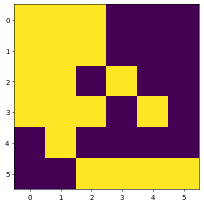

In [32]:
env.render()

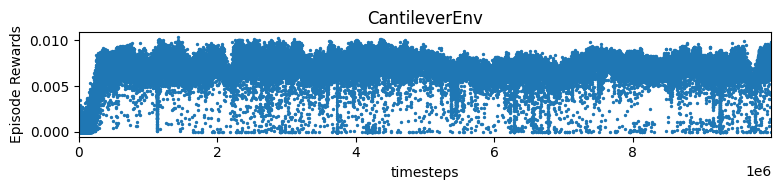

In [33]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [34]:
obs=env.reset()
obs=obs[0]

In [35]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip", env=env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [36]:
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, _,info = env.step(int(action))
    if dones:
        break
    i+=1

In [37]:
i

36


Final Cantilever beam design:


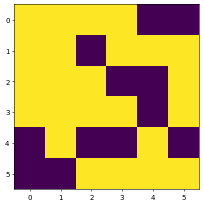

In [38]:
env.render()